In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd 

C:\Users\Mateusz\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def gaussian_k(x0,y0,sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        x = np.arange(0, width, 1, float) ## (width,)
        y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
        return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width ,points,sigma):
        """ Generate a full Heap Map for every points in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
        """
        hm = np.zeros((height, width, len(points)), dtype = np.float32)
        for i in range(len(points)):
            hm[:,:,i] = gaussian_k(points[i][0],
                                    points[i][1],
                                    sigma, width, height)
        return hm
    
def get_y_as_heatmap(df,height,width, sigma):
    columns_lmxy = df.columns[1:]
    
    columns_lm = [] 
    for c in columns_lmxy:
        c = c[1:]
        if c not in columns_lm:
            columns_lm.extend([c])
    
    y_train = []
    for i in range(df.shape[0]):
        landmarks = []
        for colnm in columns_lm:
            x = df['x'+colnm].iloc[i] / 5.
            y = df['y'+colnm].iloc[i] / 5.
            if np.isnan(x) or np.isnan(y):
                x, y = -1, -1
            landmarks.append([x,y])
        y_train.append(generate_hm(height, width, landmarks, sigma))
    y_train = np.array(y_train)
    
    return(y_train,df[columns_lmxy],columns_lmxy)

In [3]:
def load(width=128,height=96,sigma=5):#96, 96
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    heatmaps:  2-d numpy array (Nsample, Nlandmarks*2) 
        In total there are 15 landmarks. 
        As x and y coordinates are recorded, u.shape = (Nsample,30)
    df_points: panda dataframe containins the landmarks
       
    """
    from sklearn.utils import shuffle
    
    path = "./data/keypoints.csv"
    df = pd.read_csv(os.path.expanduser(path)) 

    heatmaps, df_points, df_points_labels = get_y_as_heatmap(df,height,width, sigma)
    heatmaps, df_points = shuffle(heatmaps, df_points, random_state=42)
    heatmaps = heatmaps.astype(np.float32)
    
    return heatmaps, df_points, df_points_labels

In [4]:
sigma = 3

heatmaps, df_points, df_points_labels = load(sigma=sigma)

In [5]:
from pathlib import Path
root = Path().cwd()/"data"

images = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    image_size=(96, 128),
)

Found 634 files belonging to 1 classes.


## Visualize image together with heatmap

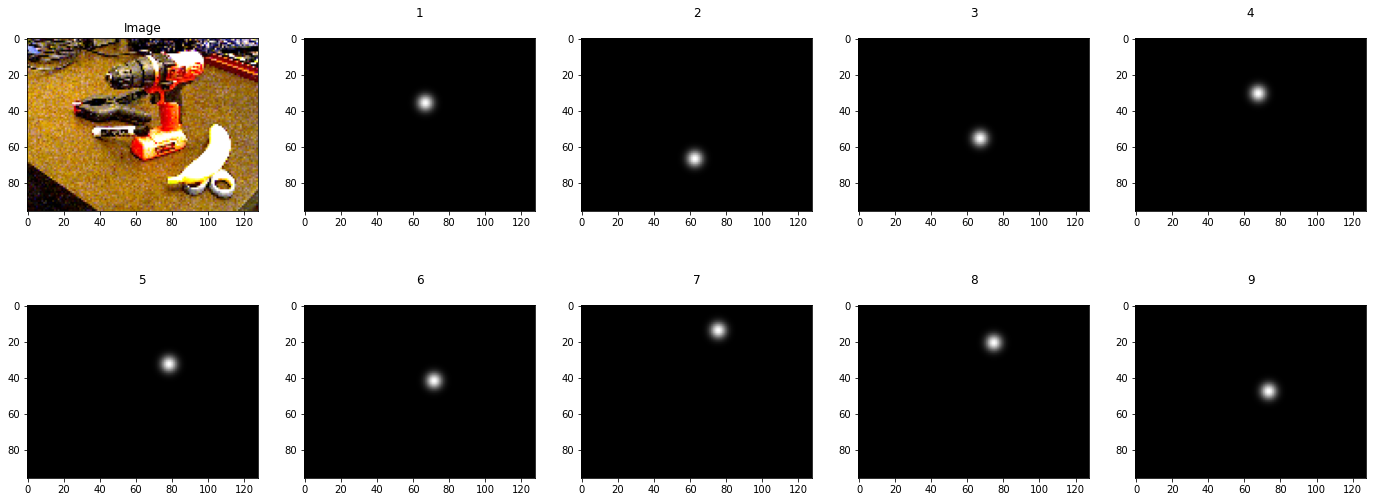

In [6]:
Nplot = heatmaps.shape[3]+1

for image, _ in images.take(1):
    for i in range(1):
        fig = plt.figure(figsize=(24,9))
        ax = fig.add_subplot(2, Nplot/2, 1)
        ax.imshow(image[i].numpy().astype("uint8"))
        ax.set_title("Image")
        for j, lab in enumerate(df_points_labels[::2]):
            ax = fig.add_subplot(2, Nplot/2, j+2)
            ax.imshow(heatmaps[i,:,:,j],cmap="gray")
            ax.set_title(str(j + 1) +"\n" + lab[:-2] )
        plt.show()